
# Accuracy
This notebook compares numerical travel time of first, third, and fifth order Lax-Friedrich schemes on a relatively coarse 3D grid.

In [1]:
using SeisTimes 
using GLMakie 
Makie.inline!(true);

#### Define velocity model and calculate travel times with:
- Lax-Friedrich 1st Order scheme: LxFS1
- Lax-Friedrich 3st Order scheme: LxFS3
- Lax-Friedrich 5st Order scheme: LxFS5

In [2]:
h = 25
x_coords = 0:h:1000 
y_coords = 0:h:1000 
z_coords = 0:h:1000 
nx,ny,nz = length(x_coords), length(y_coords), length(z_coords)

vp  = zeros(nx,ny,nz) .+ 2000
vs  = zeros(nx,ny,nz) .+ 1000

iso = Solid3D(x_coords, y_coords, z_coords, vp, vs);

sources = [(500,500,500)]
TP1 = fast_sweep(iso, sources, :P, :LxFS1, verbose=false, max_iter=250, max_error_tol = 1e-5, viscosity_buffer = 2);
TP3 = fast_sweep(iso, sources, :P, :LxFS3, verbose=false, max_iter=250, max_error_tol = 1e-5, viscosity_buffer = 2);
TP5 = fast_sweep(iso, sources, :P, :LxFS5, verbose=false, max_iter=250, max_error_tol = 1e-5, viscosity_buffer = 2);

#### Reference solution

In [3]:
function tt_ana_hom_3d(x_coords, y_coords, z_coords, velocity, source)
    nx, ny, nz = length(x_coords), length(y_coords), length(z_coords)
    x0, y0, z0 = source
    tt = zeros(nx, ny, nz)
    for ix in 1:nx, iy in 1:ny, iz in 1:nz
        x, y, z = x_coords[ix], y_coords[iy], z_coords[iz]
        dist = sqrt((x - x0)^2 + (y - y0)^2 + (z - z0)^2)
        tt[ix, iy, iz] = dist / velocity[ix,iy,iz]
    end
    return tt
end

TP_ana = tt_ana_hom_3d(x_coords, y_coords, z_coords, vp, sources[1]);

#### Visualize

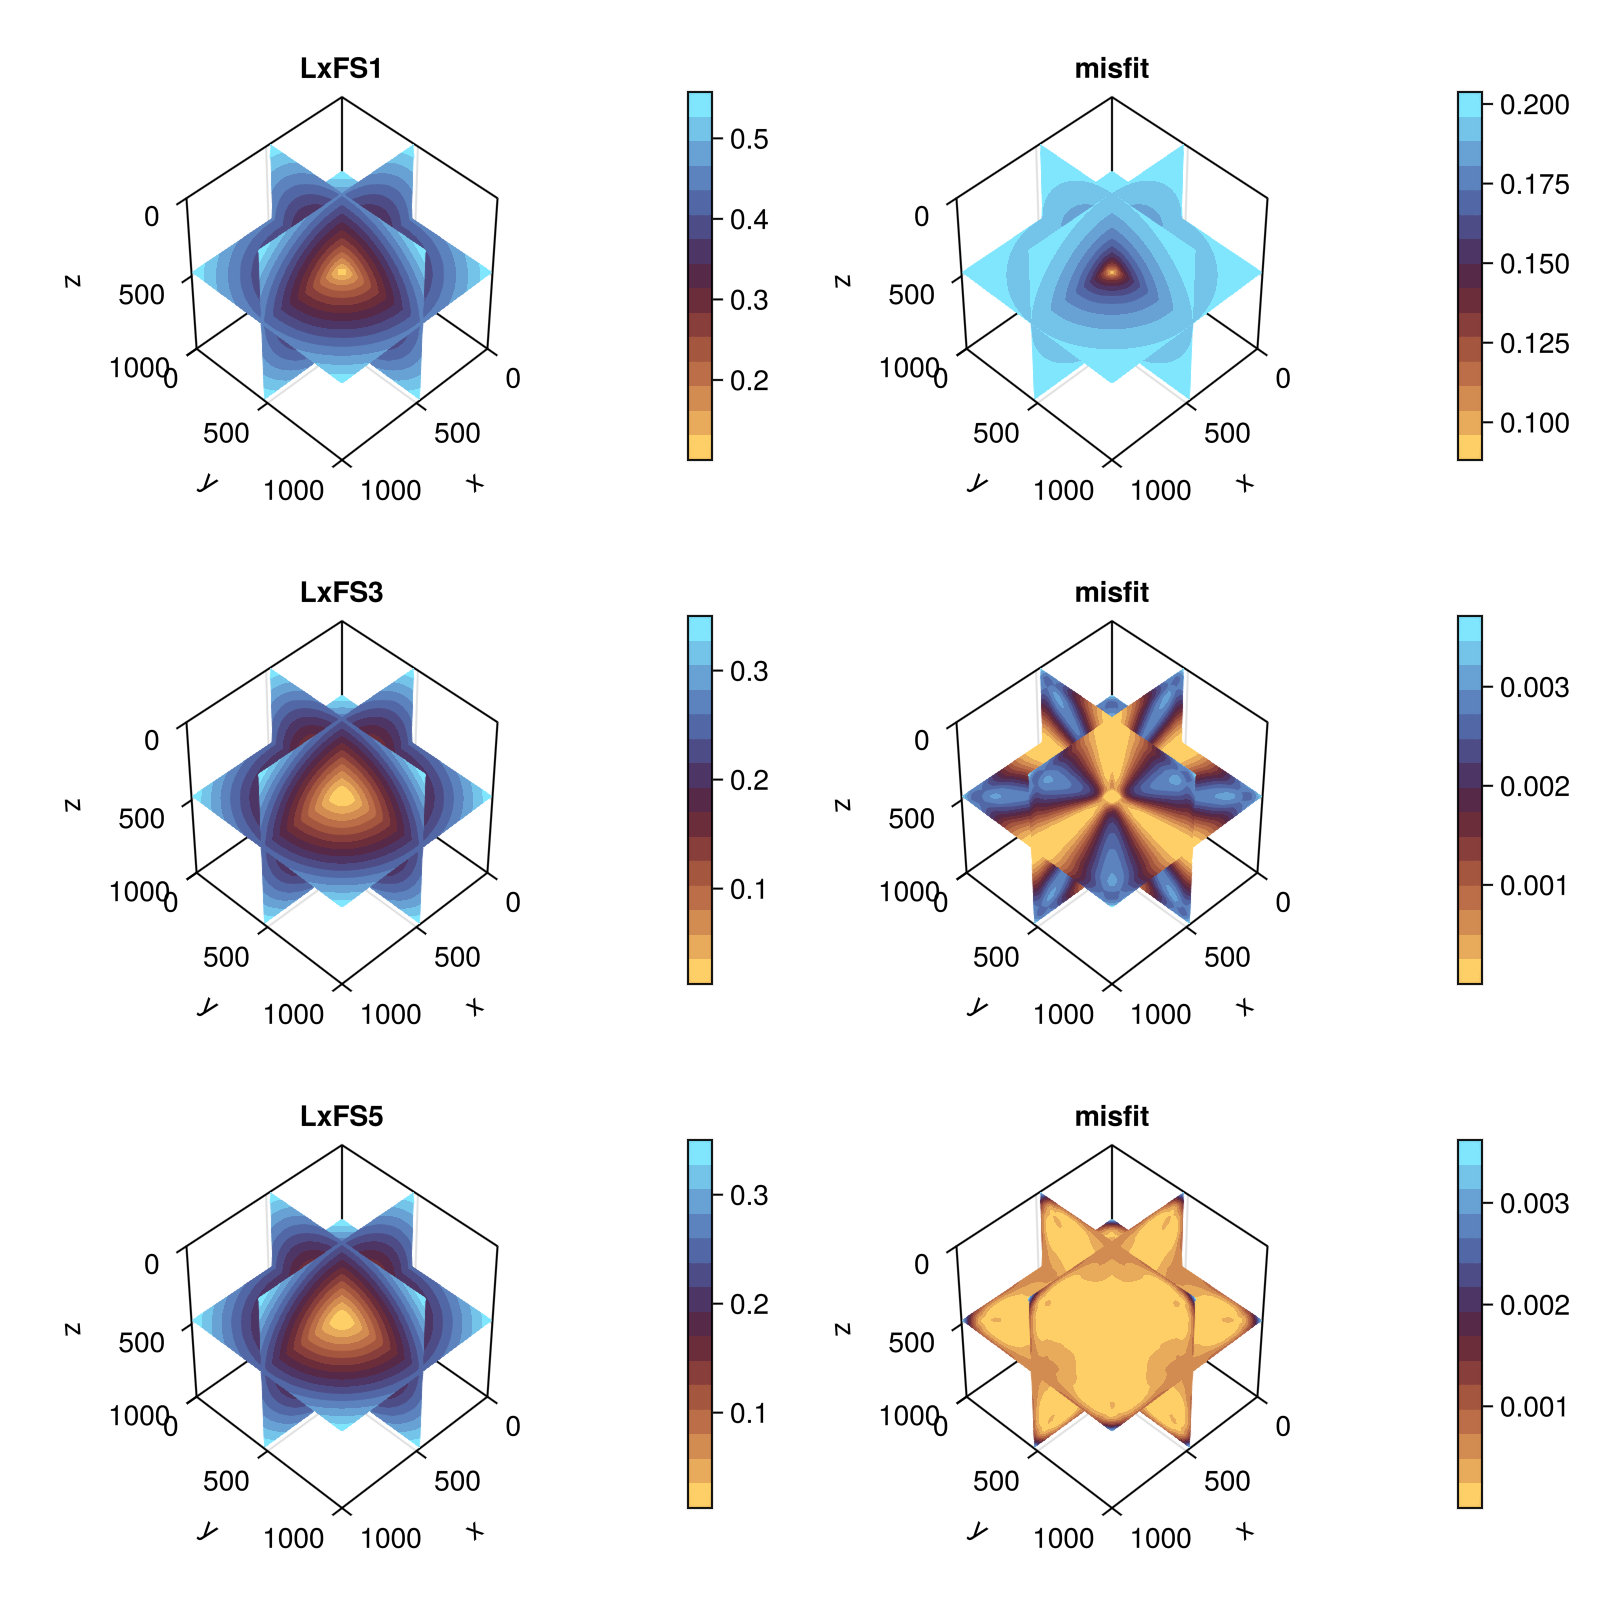


Errors:
LxFS1   L2 = 51.029   L∞ = 0.208
LxFS3   L2 = 0.631   L∞ = 0.004
LxFS5   L2 = 0.182   L∞ = 0.005


In [5]:
function L2(x, y)
    return sqrt(sum((x .- y).^2))
end

function L∞(x, y)
    return maximum(abs.(x .- y))
end

fig = Figure(size=(800,800)) 
imgs = [TP1, TP3, TP5]

xmid = Int(floor(length(x_coords)/2))
ymid = Int(floor(length(y_coords)/2))
zmid = Int(floor(length(z_coords)/2))

elevation = deg2rad(45)
azimuth = deg2rad(45)

ordernames = ["LxFS1", "LxFS3", "LxFS5"]
cmap = :managua25
grid = fig[1:3, 1:4]  

l2 = [] 
l∞ = []

for i in 1:3

    img = imgs[i]

    # choose image range 
    xrange = 1:size(img,1)
    yrange = 1:size(img,2)
    zrange = 1:size(img,3)

    x_coords_cut = x_coords[xrange]
    y_coords_cut = y_coords[yrange]
    z_coords_cut = z_coords[zrange]

    misfit = abs.(TP_ana .- img)
    XY = [img[xrange, yrange, zmid], misfit[xrange, yrange, zmid]]
    XZ = [img[xrange, ymid, zrange], misfit[xrange, ymid, zrange]]
    YZ = [img[xmid, yrange, zrange], misfit[xmid, yrange, zrange]]

    push!(l2, L2(img, TP_ana))
    push!(l∞, L∞(img, TP_ana))

    for j in 1:2

        name = j == 1 ? ordernames[i] : "misfit"
        col  = j == 1 ? 1 : 3  

        ax = Axis3(fig[i, col]; aspect=(1,1,1), zreversed=true, title=name,
                elevation=elevation, azimuth=azimuth, perspectiveness=0.1)

        xy = contourf!(ax, x_coords_cut, y_coords_cut, XY[j], levels=15,colormap=cmap,
            transformation=(:xy, z_coords[zmid]))

        xz = contourf!(ax, x_coords_cut, z_coords_cut, XZ[j], levels=15,colormap=cmap,
                    transformation=(:xz, y_coords[ymid]))

        yz = contourf!(ax, y_coords_cut, z_coords_cut, YZ[j], levels=15,colormap=cmap,
                    transformation=(:yz, x_coords[xmid]))

        Colorbar(fig[i, col + 1], yz)

        xlims!(ax, x_coords[1], x_coords[end])
        ylims!(ax, y_coords[1], y_coords[end])
        zlims!(ax, z_coords[end], z_coords[1])
    end
end

display(fig)

println("\nErrors:")
for i in 1:3
    println(rpad(ordernames[i], 8), 
            "L2 = ", round(l2[i], digits=3), "   ",
            "L∞ = ", round(l∞[i], digits=3))
end

The first-order scheme has significant errors, while the third- and fifth-order schemes have satisfactory accuracy. In the fifth-order scheme, the largest errors occur near the boundaries.